In [1]:
import math
from pathlib import Path

import torch
import jax
import numpy as np
import nibabel as nib
import pandas as pd
import tensorly as tl
from tensorly.decomposition import tucker
from tqdm.notebook import tqdm

class BrainDataset(torch.utils.data.Dataset):
    
    def __init__(self,
                 data_path: str='../../ds000201-download/',
                 task: str='_task-rest_bold.nii.gz',
                 tsv_path: str='../../ds000201-download/participants.tsv',
                 time_idx: int=190,
                 exclude: list=None,):
        
        self.__dict__.update(locals())
        if not exclude:
            self.exclude = ['sub-9016', 'sub-9022', 'sub-9044', 'sub-9066', 'sub-9078', 'sub-9095']
        
        self._setup_()
        self.participants = pd.read_csv(tsv_path, sep='\t')   
    
    def _setup_(self):
        # Setup Paths
        paths = sorted(Path(self.data_path).rglob(f'*{self.task}'))
        
        self.paths = []
        for idx, p in enumerate(paths):
            if any([e in p.name for e in self.exclude]):
                print(f'Skipping: {p.name}')
                continue
            self.paths.append(p)
    
        # Set Train Test Split
        

    def __load_fmri__(self, path) -> torch.Tensor:
        
        trueShape = (128, 128, 49)
        img = nib.load(path)
        
        if img.shape[:-1] != trueShape:
            print(f"Error: Shape is {img.shape} not {trueShape}")
            return None
        
        data = img.get_fdata()[:, :, :, :self.time_idx]
        data = torch.tensor(data, dtype=torch.float32)
        
        # Repeat the last entry of the time series until it matches the expect dimensions
        # Happy batching, happy life
        if data.shape[-1] < self.time_idx:
            missing_dim = self.time_idx - data.shape[-1]
            repeat = torch.tensor([data[:, :, :, -1].tolist() for _ in range(missing_dim)])
            repeat = torch.movedim(repeat,0, -1)
            data = torch.cat((data, repeat), axis=-1)
        return data
        
        
    def __len__(self):
        return(len(self.paths))
    
    
    def __getitem__(self, idx) -> (torch.Tensor, torch.Tensor):
        p = self.paths[idx]
        pid = p.name.split('_')[0]
        sleep_deprived_label = torch.tensor((self.participants[self.participants['participant_id'] == pid]['Sl_cond']  - 1).item(), dtype=torch.long)

        data = self.__load_fmri__(str(p))
        return (data, sleep_deprived_label)

    


dataset = BrainDataset()

rng = np.random.default_rng(seed=42)
indices = list(range(len(dataset)))
rng.shuffle(indices)
split = math.floor(len(dataset) *.8)
train_slice = indices[:split]
test_slice = indices[split:]

training_set = torch.utils.data.Subset(dataset, train_slice)
eval_set = torch.utils.data.Subset(dataset, test_slice)

# training_dl = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True) 
training_dl = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=False) 
eval_dl = torch.utils.data.DataLoader(eval_set, batch_size=32, shuffle=True) 

Skipping: sub-9016_ses-1_task-rest_bold.nii.gz
Skipping: sub-9022_ses-1_task-rest_bold.nii.gz
Skipping: sub-9044_ses-1_task-rest_bold.nii.gz
Skipping: sub-9066_ses-1_task-rest_bold.nii.gz
Skipping: sub-9095_ses-1_task-rest_bold.nii.gz


In [2]:
dataset.__load_fmri__('../../ds000201-download/sub-9047/ses-1/func/sub-9047_ses-1_task-rest_bold.nii.gz').shape

torch.Size([128, 128, 49, 190])

In [3]:

full_dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False) 
tl.set_backend('pytorch') # Or 'mxnet', 'numpy', 'tensorflow', 'cupy' or 'jax'
full_labels = None
full_data = None
full_factos = None


rank = 10
# rank = [5, 5, 5, 190]


def get_tucker(x, rank=5):
    core, factors = tucker(tl.tensor(x), rank=rank)
    return core.flatten(), core.flatten()

full_factors = []
for data in tqdm(full_dl):
    x, labels = data
    bs = x.shape[0]
    ts = x.shape[-1]
    
    # assert len(rank) == x.ndim
    # decom_x = torch.stack([get_tucker(tensor).core.flatten() for d in range(2)])
    # decom_x.shape
    
    reduce_data, factors = get_tucker(x.squeeze(), rank)
    if full_labels is not None:
        full_labels = torch.vstack([full_labels, labels])
        full_data = torch.vstack([full_data, reduce_data])
        full_factors = torch.vstack([full_factors, factors])
    else:
        full_labels = labels
        full_data = reduce_data
        full_factors = factors
        
data_dict = {'data': full_data.view(160, -1),
 'factors': full_factors.view(160, -1),
 'labels': full_labels}

torch.save(data_dict, 'task_rest.pt')

  0%|          | 0/160 [00:00<?, ?it/s]

/home/ham/.pyenv/versions/miniconda3-3.9.1/envs/mlsp/lib/python3.7/site-packages/tensorly/backend/pytorch_backend.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)
/home/ham/.pyenv/versions/miniconda3-3.9.1/envs/mlsp/lib/python3.7/site-packages/tensorly/tucker_tensor.py:357: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 4. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)
/home/ham/.pyenv/versions/miniconda3-3.9.1/envs/mlsp/lib/python3.7/site-packages/tensorly/backend/core.py:885: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'
/home/ham/.pyenv/versions/miniconda3-3.9.1/envs/mlsp/lib/python3.7/site-packages/tensorly/backend/

In [4]:
import math

%matplotlib inline
import IPython.display as ipd
import numpy as np
import jax.numpy as jnp

def jnp_svd(X):
    # Fast implementation of SVD see https://towardsdatascience.com/turbocharging-svd-with-jax-749ae12f93af
    # Compute full SVD
    U, Sigma, Vh = jnp.linalg.svd(X, 
                                  full_matrices=False, # It's not necessary to compute the full matrix of U or V
                                  compute_uv=True)
    return U, Sigma, Vh



def pca(x: np.ndarray, comp: int, verbose: bool=False) -> (np.ndarray, np.ndarray):
    n, n_samples = x.shape
    mu = jnp.tile(x.mean(axis=-1), (n_samples, 1)).T
    x_mean = (x - mu)
    C = jnp.cov(x_mean)
   
    
    U, S, V = jnp_svd(C)
#     U, S, V = np.linalg.svd(C) # NOTE: SLOW
    
    U = U[:, :comp]
    z = U.T @ x_mean
    x_ = ((U @ z) + mu)
    check_pca = (((z  @ z.T))  / n_samples)
    if verbose:
        print(f"X shape: {x.shape}")
        print(f"Mu shape {mu.shape}")
        print(f"C shape: {C.shape}")
        print(f"X_mean shape: {x_mean.shape}")
        print(f"U shape: {U.shape}")
        print(f"Z shape: {z.shape}")
        print(f"X_hat shape: {x_.shape}")
    
    # Issues with my PCA :/
    # assert np.allclose(check_pca, np.eye(comp), 1e-3), f"Issue with pca (z @ z.T != I)\n{'='*50}\n{check_pca} " 
    return z, x_, U


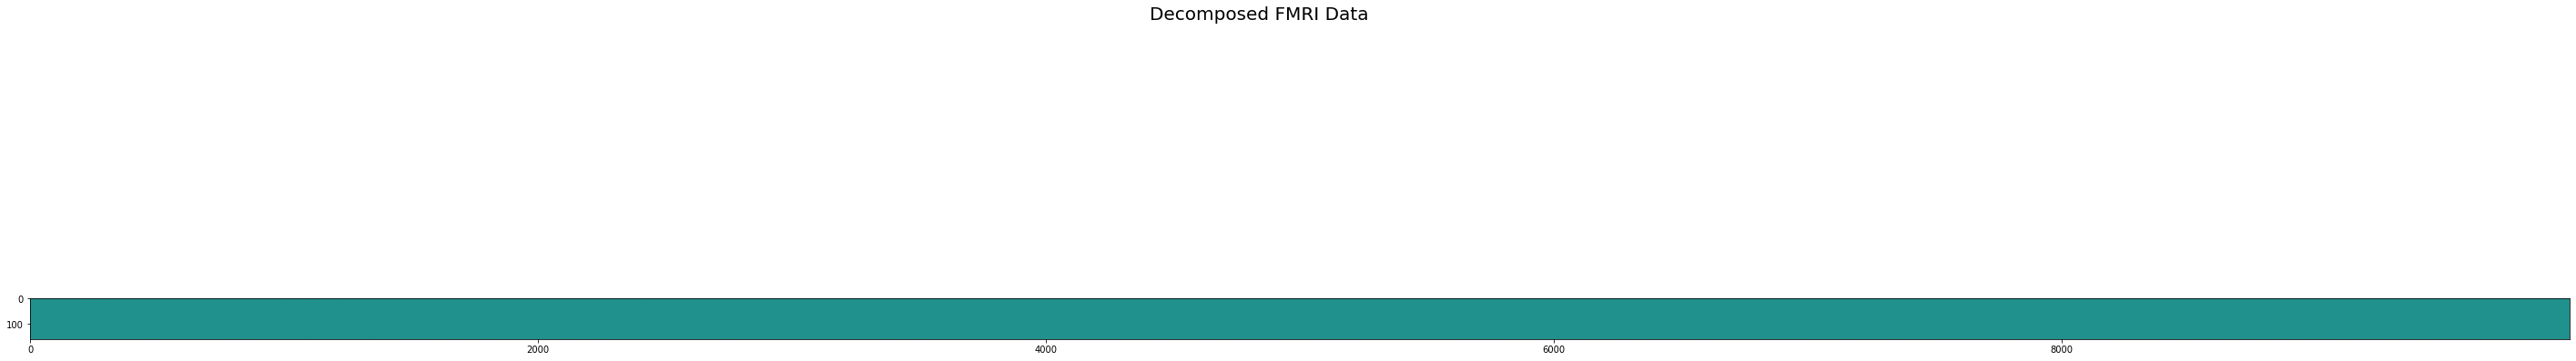

In [8]:
# %matplotlib inline
import matplotlib.pyplot as plt
data = torch.load('task_rest.pt')
x, y = data['data'], data['labels']

# z, _, _ = pca(x.cpu().numpy(), 2)
fig = plt.figure(figsize=(50, 10))
fig.suptitle('Decomposed FMRI Data', fontsize=20)
plt.imshow(x)

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import confusion_matrix

classes = ["Sleep Deprived", "Well Rested"]

def multilabel_compare(pred, gt, Model):
    conf_mat = confusion_matrix(gt, pred).astype(float)
    conf_mat /= conf_mat.sum(1, keepdims=True) * 0.01
    print(f'{Model:<25}' + str().join([f'{clsss}: {score:.4f}% \t' for clsss, score in zip(classes, conf_mat.max(1))]))
    
    
N_CLASSES = 2
kmeans = KMeans(N_CLASSES).fit(x)
gmm = GaussianMixture(N_CLASSES, covariance_type='diag').fit(x)
hmm = GaussianHMM(N_CLASSES, covariance_type='diag').fit(x)

kmeans = kmeans.labels_
gmm = gmm.predict(x)
hmm = hmm.predict(x)


header = "Model Accuracy"
center_offset = 50+len(header)//2                                                                                                        
print(f'{header:>{center_offset}}\n{"="*100}')
multilabel_compare(y, kmeans, 'K Means')
multilabel_compare(y, hmm, 'HMM Model')
multilabel_compare(y, gmm, 'Gaussian Mixture Model')


                                           Model Accuracy
K Means                  Sleep Deprived: 54.1667% 	Well Rested: 53.4091% 	
HMM Model                Sleep Deprived: 55.1402% 	Well Rested: 50.9434% 	
Gaussian Mixture Model   Sleep Deprived: 50.9434% 	Well Rested: 55.1402% 	
